In [1]:
%cd yolor

C:\Users\user\Desktop\jh\yolor


In [4]:
from glob import glob

all_train_label_list = glob("../dataset/train-001/labels/*.txt")
sample_train_label_list = glob("../dataset/train-001-copy/labels/*.txt")

print(len(all_train_label_list), len(sample_train_label_list))

24650 24650


In [5]:
def yolobbox2bbox(x, y, w, h, w_t, h_t):
    x1, y1 = (x - (w / 2.0)) * w_t, (y - (h / 2.0)) * h_t
    x2, y2 = (x + (w / 2.0)) * w_t, (y + (h / 2.0)) * h_t
    x1 = round(x1, 1)
    y1 = round(y1, 1)
    x2 = round(x2, 1)
    y2 = round(y2, 1)
    
    return (x1, y1, x2, y2)

def IoU(box1, box2): # box = (x1, y1, x2, y2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    # obtain x1, y1, x2, y2 of the intersection
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # compute the width and height of the intersection
    w = max(0, x2 - x1 + 1)
    h = max(0, y2 - y1 + 1)

    inter = w * h
    iou = inter / (box1_area + box2_area - inter)
    
    return iou

def bbox2yolobbox(x1, y1, x2, y2, w_t, h_t):
    x = (x2 + x1) / (2 * w_t)
    y = (y2 + y1) / (2 * h_t)
    w = (x2 - x1) / w_t
    h = (y2 - y1) / h_t
    
    return (x, y, w, h)

# Cropping Objects

In [87]:
from tqdm import tqdm

target_class = 10
num_class_target = 0
class_target_list = []

for train_labels in tqdm(all_train_label_list): # 1 txt file
    with open(train_labels, 'r', encoding='utf-8') as f:
        label = f.readlines() # 1 txt file labels
        for lab in label: # 1 line, in 1 txt file
            lab = lab.split(' ')
            cls, x, y, w, h = int(lab[0]), float(lab[1]), float(lab[2]), float(lab[3]), float(lab[4])
    
            if cls == target_class:
                num_class_target += 1
                
                class_target = {}
                class_target['cls'] = cls
                class_target['x'], class_target['y'], class_target['w'], class_target['h'] = x, y, w, h
                class_target['bbox'] = yolobbox2bbox(x, y, w, h, 1920, 1080)
                class_target['id'] = num_class_target
                class_target['crop_img_path'] = train_labels
                #print("class:", cls, x, y, w, h, "\tbbox:", yolobbox2bbox(x, y, w, h, 1920, 1080))
                
                class_target_list.append(class_target)
    
print("Class Num:", num_class_target)
#class_12_list

100%|███████████████████████████████████████████████████████████████████████████| 24650/24650 [00:55<00:00, 444.72it/s]

Class Num: 356


In [88]:
len(class_target_list)

356

# Finding Objects to Change with Cropped Objects

In [78]:
class_target_list

[{'cls': 6,
  'x': 0.82474,
  'y': 0.386111,
  'w': 0.061979,
  'h': 0.044444,
  'bbox': (1524.0, 393.0, 1643.0, 441.0),
  'id': 1,
  'crop_img_path': '../dataset/train-001/labels\\20201103_경기도_-_-_맑음_주간_실외_front_000035_0039836.txt'},
 {'cls': 6,
  'x': 0.116927,
  'y': 0.39537,
  'w': 0.074479,
  'h': 0.22037,
  'bbox': (153.0, 308.0, 296.0, 546.0),
  'id': 2,
  'crop_img_path': '../dataset/train-001/labels\\20201128_경상북도_영천시_-_맑음_주간_실외_back_0001219.txt'},
 {'cls': 6,
  'x': 0.211458,
  'y': 0.27037,
  'w': 0.10625,
  'h': 0.159259,
  'bbox': (304.0, 206.0, 508.0, 378.0),
  'id': 3,
  'crop_img_path': '../dataset/train-001/labels\\20201128_경상북도_영천시_-_맑음_주간_실외_back_0001220.txt'},
 {'cls': 6,
  'x': 0.267448,
  'y': 0.230093,
  'w': 0.111979,
  'h': 0.123148,
  'bbox': (406.0, 182.0, 621.0, 315.0),
  'id': 4,
  'crop_img_path': '../dataset/train-001/labels\\20201128_경상북도_영천시_-_맑음_주간_실외_back_0001221.txt'},
 {'cls': 6,
  'x': 0.304948,
  'y': 0.190741,
  'w': 0.103646,
  'h': 0.085185,
  

In [89]:
from tqdm import tqdm

object_count = 0
selected_label_list = []
selected_object_list = []

for train_labels in tqdm(sample_train_label_list): # 1 txt file
    with open(train_labels, 'r', encoding='utf-8') as f:
        label = f.readlines() # 1 txt file labels
        
        for line, lab in enumerate(label): # 1 line, in 1 txt file
            lab = lab.split(' ')
            cls, x, y, w, h = int(lab[0]), float(lab[1]), float(lab[2]), float(lab[3]), float(lab[4])
            
            for class_target in class_target_list: # Cropped Class List
                
                if cls == 7: # 세단
                    bbox1 = yolobbox2bbox(x, y, w, h, 1920, 1080)
                    bbox2 = yolobbox2bbox(x, y, class_target['w'], class_target['h'], 1920, 1080)
                    iou = IoU(bbox1, bbox2)

                    if iou >= 0.99:
                        #print("class:", cls, x, y, w, h, "\tbbox:", yolobbox2bbox(x, y, w, h, 1920, 1080), "\tIoU:", iou)
                        object_count += 1
                        
                        selected_object = {}
                        selected_object['cls'] = cls
                        selected_object['x'], selected_object['y'], selected_object['w'], selected_object['h'] = x, y, w, h
                        selected_object['bbox'] = yolobbox2bbox(x, y, w, h, 1920, 1080)
                        selected_object['iou'] = iou
                        selected_object['crop_obj'] = class_target['id']
                        selected_object['txt_line_num'] = line
                        selected_object['txt_path'] = train_labels
                        selected_object['to_cls'] = class_target['cls']
                        selected_object['to_x'], selected_object['to_y'], selected_object['to_w'], selected_object['to_h'] = class_target['x'], class_target['y'], class_target['w'], class_target['h']
                        changed_line = str(class_target['cls']) + " " + str(x) + " " + str(y) + " " + str(class_target['w']) + " " + str(class_target['h'])
                        selected_object['crop_img_bbox'] = class_target['bbox']
                        selected_object['changed_line'] = changed_line
                        selected_object['crop_txt_path'] = class_target['crop_img_path']
                        selected_object_list.append(selected_object)
                        selected_label_list.append(train_labels)
                        break

print("\nFinished with Object Num:", object_count)
print(len(selected_object_list))

100%|███████████████████████████████████████████████████████████████████████████| 24650/24650 [00:30<00:00, 802.17it/s]


Finished with Object Num: 707
707


In [90]:
selected_object_list

[{'cls': 7,
  'x': 0.915885,
  'y': 0.056944,
  'w': 0.016146,
  'h': 0.047222,
  'bbox': (1743.0, 36.0, 1774.0, 87.0),
  'iou': 1.0,
  'crop_obj': 82,
  'txt_line_num': 1,
  'txt_path': '../dataset/train-001-copy/labels\\20201102_경기도_-_-_맑음_주간_실외_right_000007_0112123.txt',
  'to_cls': 10,
  'to_x': 0.29401,
  'to_y': 0.406019,
  'to_w': 0.016146,
  'to_h': 0.047222,
  'crop_img_bbox': (549.0, 413.0, 580.0, 464.0),
  'changed_line': '10 0.915885 0.056944 0.016146 0.047222',
  'crop_txt_path': '../dataset/train-001/labels\\20201103_경기도_-_-_맑음_주간_실외_front_000057_0108746.txt'},
 {'cls': 7,
  'x': 0.028385,
  'y': 0.153241,
  'w': 0.008854,
  'h': 0.056481,
  'bbox': (46.0, 135.0, 63.0, 196.0),
  'iou': 1.0,
  'crop_obj': 238,
  'txt_line_num': 3,
  'txt_path': '../dataset/train-001-copy/labels\\20201102_경기도_-_-_맑음_주간_실외_right_000012_0084036.txt',
  'to_cls': 10,
  'to_x': 0.865885,
  'to_y': 0.381944,
  'to_w': 0.008854,
  'to_h': 0.056481,
  'crop_img_bbox': (1654.0, 382.0, 1671.0, 443.0

In [91]:
print(len(selected_label_list))
selected_label_set = set(selected_label_list) # 집합 set으로 변환
new_selected_label_set = list(selected_label_set) # list로 변환
print(len(new_selected_label_set))

707
668


In [92]:
def edit_txt_file(text_file_path, line_num, new_line): # Edit One Line in TXT File
    new_text_content = ''
    with open(text_file_path,'r') as f:
        lines = f.readlines()
        for i, l in enumerate(lines):
            if i == line_num:
                new_string = new_line
            else:
                new_string = l.strip()

            if new_string:
                new_text_content += new_string + '\n'
            else:
                new_text_content += '\n'
                
    with open(text_file_path,'w') as f:
        f.write(new_text_content)

In [93]:
def put_crop_img(selected_object, crop_path, origin_path):
    crop_src = np.fromfile(crop_path + selected_object['crop_txt_path'].split("\\")[1].split('.')[0] + ".png", np.uint8)
    crop_src = cv2.imdecode(crop_src, cv2.IMREAD_COLOR)

    crop_img = crop_src[int(selected_object['crop_img_bbox'][1]):int(selected_object['crop_img_bbox'][3]), int(selected_object['crop_img_bbox'][0]):int(selected_object['crop_img_bbox'][2])].copy()
    
    width = crop_img.shape[1]
    height = crop_img.shape[0]
    
    src = np.fromfile(origin_path + selected_object['txt_path'].split("\\")[1].split('.')[0] + ".png", np.uint8)
    src = cv2.imdecode(src, cv2.IMREAD_COLOR)
    
    max_box_shape = src[int(selected_object['bbox'][1]):height+int(selected_object['bbox'][1]), int(selected_object['bbox'][0]):width+int(selected_object['bbox'][0])].shape 
    max_width = max_box_shape[1]
    max_height = max_box_shape[0]
    
    src[int(selected_object['bbox'][1]):height+int(selected_object['bbox'][1]), int(selected_object['bbox'][0]):width+int(selected_object['bbox'][0])] = crop_img[:max_height, :max_width]

    result, encoded_img = cv2.imencode(origin_path + selected_object['txt_path'].split("\\")[1].split('.')[0] + ".png", src) 

    if result:
        with open(origin_path + selected_object['txt_path'].split("\\")[1].split('.')[0] + ".png", mode='w+b') as f:
            encoded_img.tofile(f)

In [94]:
len(selected_object_list)

707

In [95]:
import numpy as np
import cv2

for selected_object in tqdm(selected_object_list):
    edit_txt_file(selected_object['txt_path'], selected_object['txt_line_num'], selected_object['changed_line'])
    put_crop_img(selected_object, "../dataset/train-001/images/", "../dataset/train-001-copy/images/")

100%|████████████████████████████████████████████████████████████████████████████████| 707/707 [01:14<00:00,  9.46it/s]


In [41]:
# 클래스 균형 확인 코드
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def check_class_balance(path):
    cate = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    train_label_list = glob(path)

    for train_labels in tqdm(train_label_list): # 1 txt file
        with open(train_labels, 'r', encoding='utf-8') as f:
            label = f.readlines() # 1 txt file labels
            for lab in label: # 1 line, in 1 txt file
                lab = lab.split(' ')
                cls = int(lab[0])

                if cls == 0:
                    cate[0] += 1
                elif cls == 1:
                    cate[1] += 1
                elif cls == 2:
                    cate[2] += 1
                elif cls == 3:
                    cate[3] += 1
                elif cls == 4:
                    cate[4] += 1
                elif cls == 5:
                    cate[5] += 1
                elif cls == 6:
                    cate[6] += 1
                elif cls == 7:
                    cate[7] += 1
                elif cls == 8:
                    cate[8] += 1
                elif cls == 9:
                    cate[9] += 1
                elif cls == 10:
                    cate[10] += 1
                elif cls == 11:
                    cate[11] += 1
                elif cls == 12:
                    cate[12] += 1
                elif cls == 13:
                    cate[13] += 1 

    result_cate = cate
    print(result_cate)

    X = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
    Y = np.array(result_cate)

    ax = sns.barplot(X,Y, order=X)
    for p, q in zip(ax.patches, Y):
        ax.text(p.get_x()+p.get_width()/2.,
            p.get_height()*(1.01),
            "{}".format(q),
            ha = 'center'  )

    plt.show()

100%|██████████████████████████████████████████████████████████████████████████| 24650/24650 [00:03<00:00, 7980.49it/s]

[53700, 28173, 4581, 902, 1140, 3545, 1564, 20747, 496, 2674, 1592, 2966, 3664, 8997]



C:\Users\user\anaconda3\envs\yolor\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


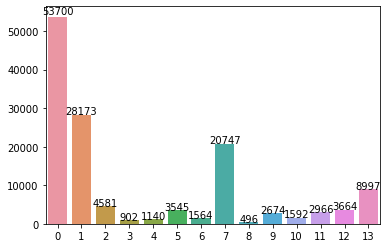

In [42]:
# Add 12, 10
check_class_balance("../dataset/train-001-copy/labels/*.txt")

100%|██████████████████████████████████████████████████████████████████████████| 24650/24650 [00:06<00:00, 3580.62it/s]

[50057, 28173, 4581, 902, 1140, 3545, 1564, 20747, 4139, 2674, 1592, 2966, 3664, 8997]



C:\Users\user\anaconda3\envs\yolor\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


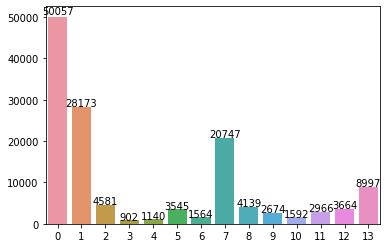

In [53]:
# Add 12, 10, 8
check_class_balance("../dataset/train-001-copy/labels/*.txt")

100%|██████████████████████████████████████████████████████████████████████████| 24650/24650 [00:06<00:00, 3735.82it/s]
C:\Users\user\anaconda3\envs\yolor\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[46618, 28173, 4581, 4341, 1140, 3545, 1564, 20747, 4139, 2674, 1592, 2966, 3664, 8997]


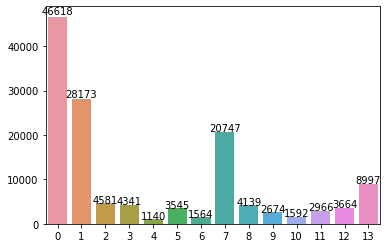

In [65]:
# Add 12, 10, 8, 3
check_class_balance("../dataset/train-001-copy/labels/*.txt")

100%|██████████████████████████████████████████████████████████████████████████| 24650/24650 [00:07<00:00, 3219.85it/s]
C:\Users\user\anaconda3\envs\yolor\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[42505, 28173, 4581, 4341, 5253, 3545, 1564, 20747, 4139, 2674, 1592, 2966, 3664, 8997]


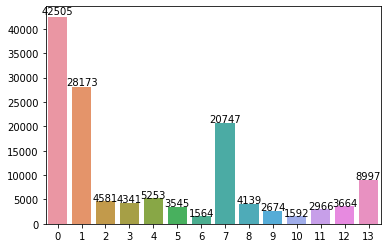

In [75]:
# Add 12, 10, 8, 3, 4
check_class_balance("../dataset/train-001-copy/labels/*.txt")

100%|██████████████████████████████████████████████████████████████████████████| 24650/24650 [00:10<00:00, 2292.05it/s]
C:\Users\user\anaconda3\envs\yolor\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[37483, 28173, 4581, 4341, 5253, 3545, 6586, 20747, 4139, 2674, 1592, 2966, 3664, 8997]


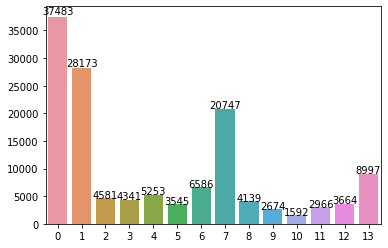

In [86]:
# Add 12, 10, 8, 3, 4, 6
check_class_balance("../dataset/train-001-copy/labels/*.txt")

100%|█████████████████████████████████████████████████████████████████████████| 24650/24650 [00:01<00:00, 14316.75it/s]
C:\Users\user\anaconda3\envs\yolor\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[37483, 28173, 4581, 4341, 5253, 3545, 6586, 20040, 4139, 2674, 2299, 2966, 3664, 8997]


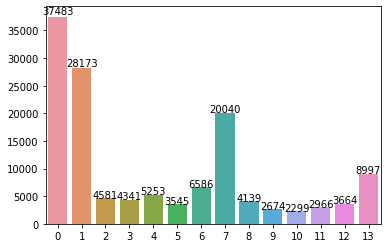

In [96]:
# Add 12, 10, 8, 3, 4, 6, 10
check_class_balance("../dataset/train-001-copy/labels/*.txt")